# Environment Wrapper for Farm

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from mcts import MCTS
from agents import * 
import farmgame  # Ensure the farmgame module is imported
from farmgame import *

# Define the FarmEnv class
class FarmEnv:
    def __init__(self, farm: Farm, reward_function=None):
        self.game = farm  # Accept a Farm instance directly
        self.done = False
        self.reward_function = reward_function or self.default_reward

    def reset(self):
        self.game = configure_game()  # Reset the game
        self.done = False
        return self.get_state()

    def step(self, action):
        current_player = self.game.whose_turn()["name"]
        self.game = self.game.take_action(action, inplace=True)  # Apply action
        reward = self.reward_function(self.game, current_player)  # Calculate reward
        self.done = self.game.is_done()  # Check if game is done
        new_state = self.get_state()  # Get the updated state
        return new_state, reward, self.done, {}  # Return updated state

    def get_state(self):
        return self.game

    def render(self):
        self.game.print_farm()

    def default_reward(self, game, player):
        return game.playersDict[player]["score"]

# Training

In [2]:
class QLearningAgent:
    def __init__(self, learning_rate=0.1, discount_factor=0.99, epsilon=0.8, seed=None):
        self.q_table = {}  # Dictionary to store Q-values
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon

        # Random seed for reproducibility (optional)
        self.seed = seed or random.randint(0, 1e6)
        random.seed(self.seed)

        self.current_state = None  # Track the latest full state

    def update(self, state):
        """
        Update the agent with the current state.
        """
        self.current_state = state  # Keep the full state object

    def get_state_representation(self, state):
        """
        Convert the state into a hashable representation for the Q-table.
        """
        return hash(str(state))  # Serialize the state to string and hash

    def get_action_representation(self, action):
        """
        Convert the action into a simplified representation for the Q-table.
        """
        return (action.type, action.loc['x'], action.loc['y'])  # Simplified action representation

    def get_q_value(self, state, action):
        """
        Retrieve the Q-value for a given state-action pair.
        """
        state_rep = self.get_state_representation(state)
        action_rep = self.get_action_representation(action)
        return self.q_table.get((state_rep, action_rep), 0.0)

    def choose_action(self):
        """
        Choose an action based on epsilon-greedy policy.
        """
        actions = self.current_state.legal_actions()  # Access legal actions from the full state
        if not actions:
            raise Exception("No legal actions available.")

        if random.random() < self.epsilon:  # Explore
            action = random.choice(actions)
            print(f"Exploring: Chose random action {action}")
            return action

        # Exploit: Choose the best action based on Q-values
        q_values = [self.get_q_value(self.current_state, a) for a in actions]
        max_q_value = max(q_values)
        best_actions = [a for a, q in zip(actions, q_values) if q == max_q_value]
        action = random.choice(best_actions)
        print(f"Exploiting: Chose action {action} with Q-value {max_q_value}")
        return action

    def update_q_value(self, action, reward, next_state):
        """
        Update the Q-value for the given state-action pair using the Q-learning formula.
        """
        # Get hashable representations of the states and action
        state_rep = self.get_state_representation(self.current_state)
        action_rep = self.get_action_representation(action)
        next_state_rep = self.get_state_representation(next_state)

        # Get the maximum Q-value for the next state
        next_actions = next_state.legal_actions()
        max_q_next = max([self.get_q_value(next_state_rep, a) for a in next_actions], default=0)

        # Compute the TD target and error
        td_target = reward + self.discount_factor * max_q_next
        td_error = td_target - self.get_q_value(self.current_state, action)

        # Update the Q-value
        new_q_value = self.get_q_value(self.current_state, action) + self.learning_rate * td_error
        self.q_table[(state_rep, action_rep)] = new_q_value

        # Debug logs
        print(f"Updated Q-value for state-action pair ({state_rep}, {action_rep}): {new_q_value}")
        print(f"Reward: {reward}, TD Target: {td_target}, TD Error: {td_error}")

    def decay_epsilon(self, decay_rate=0.99):
        """
        Decay the exploration rate (epsilon) over time.
        """
        self.epsilon = max(0.01, self.epsilon * decay_rate)
        print(f"Decayed epsilon: {self.epsilon}")


In [3]:
def train_q_learning_agent(env, num_episodes=1000, max_steps_per_episode=100):
    # Initialize two Q-learning agents
    agent1 = QLearningAgent(learning_rate=0.2, discount_factor=0.99, epsilon=0.2)
    agent2 = QLearningAgent(learning_rate=0.2, discount_factor=0.99, epsilon=0.2)

    final_rewards_red = []  # To store the final rewards of the 'red' player
    final_rewards_purple = []  # To store the final rewards of the 'purple' player
    helpful_moves_red = []  # To track the number of helpful moves for the 'red' player
    helpful_moves_purple = []  # To track the number of helpful moves for the 'purple' player

    for episode in range(num_episodes):
        # print(f"\nStarting Episode {episode + 1}/{num_episodes}")

        state = env.reset()  # Reset the environment for a new episode
        agent1.update(state)
        agent2.update(state)

        red_helpful_count = 0  # Counter for red's helpful moves
        purple_helpful_count = 0  # Counter for purple's helpful moves

        for step in range(max_steps_per_episode):
            # Agent 1's turn (Red)
            action1 = agent1.choose_action()
            transition = farmgame.Transition(state, action1)
            if transition.is_helping():
                red_helpful_count += 1

            next_state = state.take_action(action1, inplace=True)
            reward1, done = next_state.reward("red")  # Get reward for the red player
            agent1.update_q_value(action1, reward1, next_state)
            state = next_state

            if done:
                break  # End the episode if the game is over

            # Agent 2's turn (Purple)
            action2 = agent2.choose_action()
            transition = farmgame.Transition(state, action2)
            if transition.is_helping():
                purple_helpful_count += 1

            next_state = state.take_action(action2, inplace=True)
            reward2, done = next_state.reward("purple")  # Get reward for the purple player
            agent2.update_q_value(action2, reward2, next_state)
            state = next_state

            if done:
                break  # End the episode if the game is over

        # Record final rewards at the end of the episode
        red_rwd, _ = state.reward("red")
        purple_rwd, _ = state.reward("purple")
        final_rewards_red.append(red_rwd)
        final_rewards_purple.append(purple_rwd)

        # Record the number of helpful moves
        helpful_moves_red.append(red_helpful_count)
        helpful_moves_purple.append(purple_helpful_count)

        # Decay epsilon for exploration
        agent1.decay_epsilon()
        agent2.decay_epsilon()

        # Log progress every 100 episodes
        if (episode + 1) % 100 == 0:
            avg_red_reward = sum(final_rewards_red[-100:]) / 100
            avg_purple_reward = sum(final_rewards_purple[-100:]) / 100
            print(f"Episode {episode + 1}: Avg Red Reward = {avg_red_reward}, Avg Purple Reward = {avg_purple_reward}")
            print(f"Avg Helpful Moves: Red = {sum(helpful_moves_red[-100:]) / 100}, Purple = {sum(helpful_moves_purple[-100:]) / 100}")

    print("\nTraining completed.")
    return agent1, agent2, final_rewards_red, final_rewards_purple, helpful_moves_red, helpful_moves_purple

In [6]:
farm_instance = configure_game()  # Ensure this function initializes the Farm object correctly
env = FarmEnv(farm_instance)

agent1, agent2, final_rewards_red, final_rewards_purple, helpful_moves_red, helpful_moves_purple = train_q_learning_agent(env, num_episodes=100)

Exploring: Chose random action Tomato01(7,8)
Updated Q-value for state-action pair (-3998865848193521563, (<ActionType.veggie: 'veggie'>, 7, 8)): -20.0
Reward: -100, TD Target: -100.0, TD Error: -100.0
Exploring: Chose random action Eggplant00(12,14)
Updated Q-value for state-action pair (-3998865848193521563, (<ActionType.veggie: 'veggie'>, 12, 14)): -20.0
Reward: -100, TD Target: -100.0, TD Error: -100.0
Exploiting: Chose action box(16,5) with Q-value 0.0
Updated Q-value for state-action pair (-3998865848193521563, (<ActionType.box: 'box'>, 16, 5)): -0.2
Reward: -1, TD Target: -1.0, TD Error: -1.0
Exploiting: Chose action purplepillow(12,14) with Q-value 0.0
Updated Q-value for state-action pair (-3998865848193521563, (<ActionType.pillow: 'pillow'>, 12, 14)): -20.0
Reward: -100, TD Target: -100.0, TD Error: -100.0
Exploiting: Chose action Strawberry00(7,7) with Q-value 0.0
Updated Q-value for state-action pair (-3998865848193521563, (<ActionType.veggie: 'veggie'>, 7, 7)): -20.0
Rewar

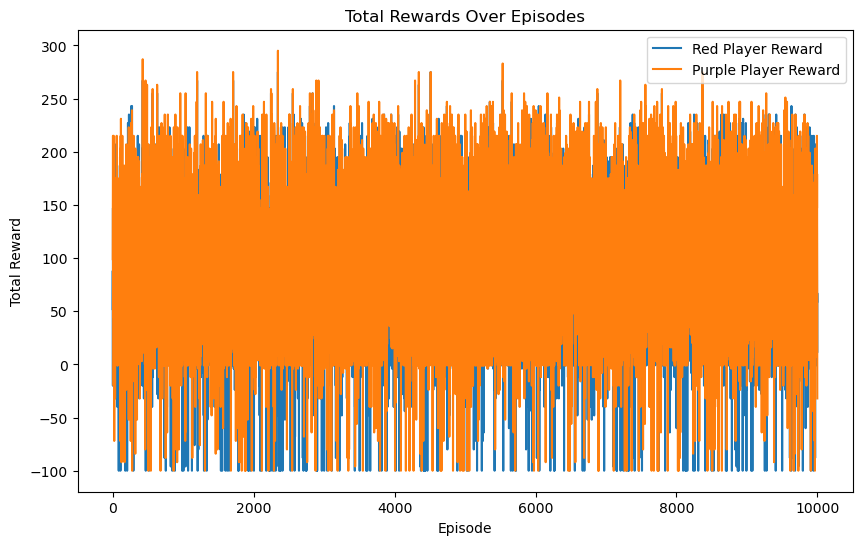

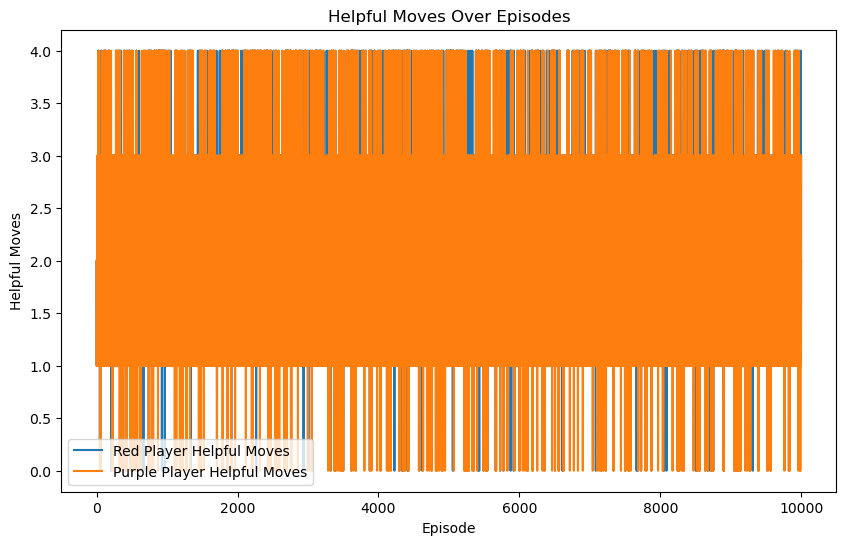

In [5]:
plt.figure(figsize=(10, 6))
plt.plot(final_rewards_red, label="Red Player Reward")
plt.plot(final_rewards_purple, label="Purple Player Reward")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Total Rewards Over Episodes")
plt.legend()
plt.show()

# Example: Plot helpful moves
plt.figure(figsize=(10, 6))
plt.plot(helpful_moves_red, label="Red Player Helpful Moves")
plt.plot(helpful_moves_purple, label="Purple Player Helpful Moves")
plt.xlabel("Episode")
plt.ylabel("Helpful Moves")
plt.title("Helpful Moves Over Episodes")
plt.legend()
plt.show()
